The following notebook goes through the process of creating the dataset needed to construct the Bayesian model which analyzes the relationship between farm infection status and various other farm covariates.

The following function simulates one outbreak and returns an array of: farmID, infection status as an indicator variable, distance of each farm to the index infected farm, number of cows at each farm, and number of sheep at each farm. Thus if we are interested in a simulation with 500 farms, this function will return an array that is 500x5.

In [65]:
def Outbreaks(Size,N,Y0,farms,start,end,x,y,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    Cows = np.array([250]*N)  #Number of cows at each farm
    Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    for i in range(Y0):
        Status[i] = 1

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(np.logical_and(Status>5, Status<=12))[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        for i in range(len(m)):
            Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<Maxtime, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(np.logical_and(Status>5, Status<=9))[0]; 
        Rep=np.where(Status>9)[0]; Culled=np.where(Status<0)[0];
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); R.append(len(np.where(Status==10))); R2.append(len(Rep));CullSheep.append(np.sum(Sheep[Culled])); CullCattle.append(np.sum(Cows[Culled]))
        t.append(t[i-2]+1);i+=1;
    
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if (E[-4]+I[-4]+R2[-4]==0):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full

    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (np.logical_and(no_this[:,2]>5,no_this[:,2]<13)).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[0][0],coords[0][1]))
    dist = []
    dist.append(0)
    for i in range(1,N):
        b = np.array((coords[i][0],coords[i][1]))
        dist.append(np.linalg.norm(index-b))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep]
    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep
    return(to_return)
    
    
#import numpy as np
#Size = 20
#N = 1000    
#x = Size*np.random.rand(N)
#y = Size*np.random.rand(N)     
#Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),start=20,end=30,x=x,y=y)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:94: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:103: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.50000000e+02,   2.50000000e+02],
       [  2.00000000e+00,   0.00000000e+00,   6.56989389e-01,
          2.50000000e+02,   2.50000000e+02],
       [  3.00000000e+00,   0.00000000e+00,   9.36146705e-01,
          2.50000000e+02,   2.50000000e+02],
       ..., 
       [  9.98000000e+02,   1.00000000e+00,   2.62560755e+01,
          2.50000000e+02,   2.50000000e+02],
       [  9.99000000e+02,   0.00000000e+00,   2.51401969e+01,
          2.50000000e+02,   2.50000000e+02],
       [  1.00000000e+03,   1.00000000e+00,   2.53760693e+01,
          2.50000000e+02,   2.50000000e+02]])

Now that we have working code to generate a dataset for one outbreak, we need to be able to simulate the outbreak multiple times. The following code performs this action and adds a column indicating which outbreak simulation the data corresponds to. Thus, if there are 500 farms in the simulation and we repeat the simulation 10 times, the followinf code will generate an array that is 5000x5.

In [84]:
import numpy as np
Size = 20
N = 1000    
x = Size*np.random.rand(N)
y = Size*np.random.rand(N)
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),start=20,end=30,x=x,y=y)
Num_outbreaks = 100
for i in range(Num_outbreaks):
    new_Outbreak = np.r_[Outbreak,Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),start=20,end=30,x=x,y=y)]
    Outbreak = new_Outbreak 
run = np.ravel(list([i]*N for i in range(1,Num_outbreaks+2)))
data = np.c_[run,Outbreak]

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:94: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:103: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [85]:
#For ease turn data array into data frame
import pandas as pd
df = pd.DataFrame(data)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep']
df.shape

(101000, 6)

Now that you have a dataset containing information from multiple outbreak we can attempt to fit a random intercept model, where the group in this case is the simulation run. We are assuming here that there is some correlation of becoming infected within a simulation but not between, thus "run" will act as a random effect. NOTE: when you ran this the first time you had the same number of cows and sheep at each farm causing the model to not converge. If you think of this in the least-squares sense you have a non-invertible coefficient matrix. For this reason you need to have some randomness in the number of sheep and cows per farm.

In [117]:
#THIS MODEL DIDN'T CONVERGE, NEED MORE ITERATIONS OR CHANGE PRIORS
run = df['run']
dist = df['DistToIndex']
cows = df['NumCows']
sheep = df['NumSheep']
status = df['Status']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot
N = df.shape[0]

def varying_intercept():
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    tau_a = Gamma('tau_a', 1, 0.1, value=1)
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, size=len(set(run)))
    # Common slope
    b = Normal('b', mu=0., tau=0.0001, value = [0]*3)
    
    prob = Lambda('prob', lambda a=a, b=b: invlogit(a[run-1] + b[0]*dist + b[1]*cows + b[2]*sheep))
    
    y = Binomial('y', n=N, p=prob, value=status, observed=True)
    
    return locals()

In [121]:
chains = 2
iterations = 10000
burn = 5000
M_pooled = MCMC(varying_intercept())
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.beta)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 522.8 sec

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


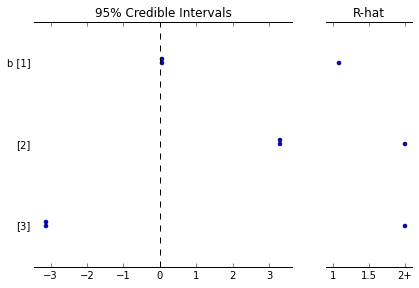

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.b)

Plotting b_0
Plotting b_1
Plotting b_2


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


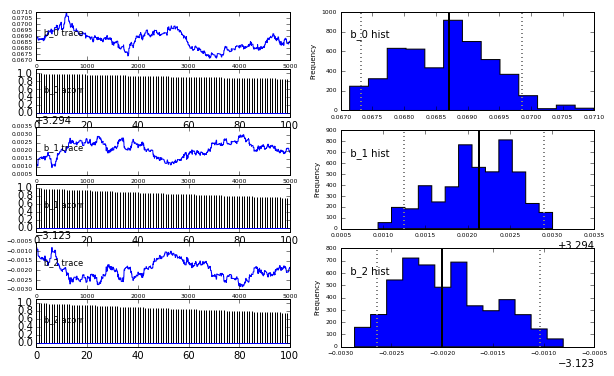

In [124]:
Matplot.plot(M_pooled.b, common_scale=False)

In [125]:
M_pooled.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.069            0.001            0.0              [ 0.066  0.071]
	3.298            0.004            0.0              [ 3.295  3.307]
	-3.127           0.004            0.0              [-3.135 -3.124]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.066            0.068           0.069          0.07          0.071
	3.294            3.296           3.297          3.299         3.307
	-3.135           -3.128          -3.125         -3.125        -3.123
	


In [ ]:
#NEED TO RUN MORE ITERATIONS TO REACH CONVERGENCE